In [1]:
ATTR_NOW = 'avg_temp'

In [2]:
attr_dict = {
    'min_temp': ('mnt', '(a) minimum temperature'),
    'max_temp': ('mxt', '(b) maksimum temperature'),
    'avg_temp': ('avgt', '(c) average temperature'),
    'avg_humidity': ('hum', '(d) humidity'),
    'sunshine': ('sun', '(e) sunshine'),
    'rainfall': ('rain', '(f) rainfall'),
}

ATTR_CODE = attr_dict[ATTR_NOW][0]
ATTR_NAME = attr_dict[ATTR_NOW][1]

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima.arima import auto_arima, ndiffs, nsdiffs

from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

import scipy.stats as stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import pickle

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('../attributes_dataset/avg_temp.csv')
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df.set_index('date', inplace=True)
df.head()

,avg_temp
date,
2018-01-01,23.0
2018-01-02,22.5
2018-01-03,22.7
2018-01-04,22.4
2018-01-05,23.6


# Splitting Data

In [6]:
train_ratio = int(len(df) * 0.9)

In [7]:
dtrain = df.iloc[:train_ratio]
dtest = df.iloc[train_ratio:]

In [8]:
print(dtrain.shape)
print(dtest.shape)

(1395, 1)
(156, 1)


# Visualisasi ACF dan PACF

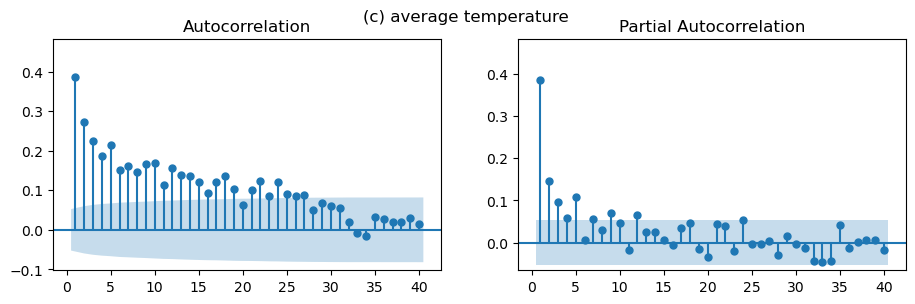

In [9]:
lags = 40

fig, ax = plt.subplots(1,2,figsize=(11,3))
plt.suptitle(ATTR_NAME, fontsize=12)
sgt.plot_acf(dtrain, lags=lags, zero=False, ax=ax[0], auto_ylims=True)
sgt.plot_pacf(dtrain, lags=lags, zero=False, ax=ax[1], auto_ylims=True)
plt.show()

Grafik ACF menurun secara eksponensial, ini berarti data sudah stasioner

jika belum grafik menurun secara perlahan, data belum stasioner sehingga perlu dilakukan differencing..

untuk lebih membuktikan bahwa data belum stasioner, maka dilakukan ACF test

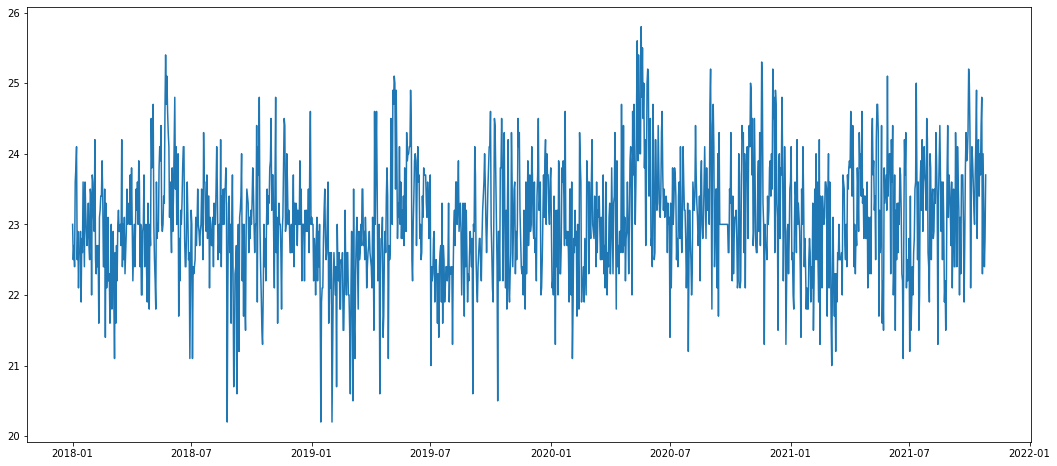

In [10]:
plt.figure(figsize=(18,8))
plt.plot(dtrain)

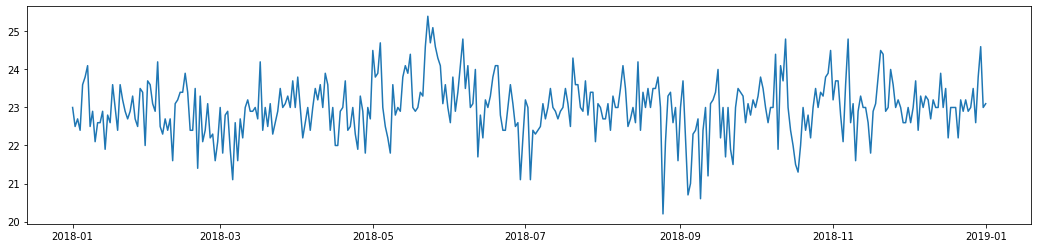

In [11]:
plt.figure(figsize=(18,4))
plt.plot(dtrain.loc['2018-01-01':'2019-01-01'])

In [12]:
dtrain.head(5)

,avg_temp
date,
2018-01-01,23.0
2018-01-02,22.5
2018-01-03,22.7
2018-01-04,22.4
2018-01-05,23.6


# Stasionary Test (dickey fuller)

In [13]:
adf = sts.adfuller(dtrain)
print(f'ADF p values\t\t: {adf[1]}')
print(f'ADF statistic values\t: {adf[0]}')
print(f'ADF critical values\t: {adf[4]}')

ADF p values		: 2.01347201385867e-09
ADF statistic values	: -6.81998020994139
ADF critical values	: {'1%': -3.4350871503340508, '5%': -2.863632105852836, '10%': -2.567883833038199}


In [14]:
# p-value < 0.05 tidak stasioner
sts.kpss(dtrain, regression='ct')

(0.07653930109726531,
 0.1,
 24,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

### Data stasioner karena p values < 0.05 dan statistic values < 5% critical values  menurut ADF TEST

### Menurut KPSS test, yang menguji Trend Stationarity.. data perlu di differencing 1 kali

# Levene Test

In [15]:
len_dtrain = len(dtrain)
levgrp_1 = dtrain.avg_temp.iloc[int(0.2*len_dtrain):int(0.6*len_dtrain)]
levgrp_2 = dtrain.avg_temp.iloc[:int(0.4*len_dtrain)]
levgrp_3 = dtrain.avg_temp.iloc[int(0.8*len_dtrain):]
levgrp_4 = dtrain.avg_temp.iloc[int(0.2*len_dtrain):int(0.9*len_dtrain)]

In [16]:
#levene p-value > 0.05 == varian stasioner

levene_val = stats.levene(levgrp_1, levgrp_2, levgrp_3, levgrp_4, center='mean')
print(levene_val)
if levene_val[1] > 0.05:
    print('Varian Stasioner')
else:
    print('Varian Tidak Stasioner')    

LeveneResult(statistic=4.493268673684077, pvalue=0.0037677858924478596)
Varian Tidak Stasioner


In [17]:
trans = boxcox(dtrain.avg_temp)
dtrain_trans = trans[0]
trans_lambdas = trans[1]

In [18]:
df_dtrain_trans = dtrain.copy()
df_dtrain_trans.avg_temp = dtrain_trans

# Auto Arima Model

In [19]:
train_exg = pd.read_csv('../R_resource/avg_temp_train_exog182.csv')
train_exg = train_exg.drop(columns='Unnamed: 0')

In [20]:
test_exg = pd.read_csv('../R_resource/avg_temp_test_exog182.csv')
test_exg = test_exg.drop(columns='Unnamed: 0')

In [21]:
print(train_exg.shape)
print(test_exg.shape)

(1395, 364)
(156, 364)


In [22]:
model_loc = f'ARIMA_models/{ATTR_NOW}.pkl'

In [23]:
## open the model

with open(model_loc, 'rb') as pkl:
    model = pickle.load(pkl)

In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1395
Model:               SARIMAX(0, 0, 5)   Log Likelihood                -975.256
Date:                Mon, 08 Aug 2022   AIC                           2692.512
Time:                        11:36:26   BIC                           4636.793
Sample:                             0   HQIC                          3419.458
                               - 1395                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     18.2894      0.084    218.264      0.000      18.125      18.454
S1-365        -0.0625      0.116     -0.540      0.589      -0.289       0.164
C1-365        -0.0877      0.121     -0.723      0.470      -0.325       0.150
S2-365        -0.2634      0.159     -1.661      0.097      -0.574       0.047
C2-365        -0.0009      0.053     -0.017      0.987      -0.106       0.104
S3-365         0.0382      0.123      0.309      0.757      -0.204       0.280
C3-365         0.0784      0.113      0.696      0.486      -0.142       0.299
S4-365        -0.0215      0.060     -0.356      0.722      -0.140       0.097
C4-365        -0.0551      0.155     -0.354      0.723      -0.360       0.250
S5-365        -0.0108      0.111     -0.097      0.923      -0.229       0.208
C5-365         0.1027      0.123      0.832      0.405      -0.139       0.345
S6-365        -0.0098      0.151     -0.065      0.948      -0.306       0.287
C6-365        -0.0707      0.068     -1.047      0.295      -0.203       0.062
S7-365        -0.0373      0.122     -0.305      0.760      -0.277       0.202
C7-365        -0.0027      0.111     -0.025      0.980      -0.220       0.214
S8-365        -0.0186      0.070     -0.265      0.791      -0.156       0.119
C8-365         0.0413      0.148      0.278      0.781      -0.250       0.332
S9-365         0.0070      0.110      0.064      0.949      -0.209       0.223
C9-365        -0.0301      0.120     -0.250      0.803      -0.266       0.206
S10-365        0.0054      0.147      0.037      0.971      -0.283       0.293
C10-365       -0.0736      0.069     -1.068      0.286      -0.209       0.061
S11-365        0.0150      0.119      0.126      0.900      -0.219       0.249
C11-365        0.0214      0.108      0.198      0.843      -0.191       0.234
S12-365       -0.0095      0.066     -0.145      0.885      -0.138       0.119
C12-365       -0.0128      0.146     -0.087      0.930      -0.299       0.273
S13-365       -0.0169      0.105     -0.160      0.873      -0.224       0.190
C13-365        0.0257      0.119      0.217      0.828      -0.207       0.259
S14-365       -0.0716      0.145     -0.494      0.621      -0.356       0.213
C14-365       -0.0084      0.061     -0.137      0.891      -0.128       0.112
S15-365        0.0522      0.121      0.432      0.666      -0.185       0.289
C15-365        0.0504      0.099      0.510      0.610      -0.143       0.244
S16-365       -0.0311      0.058     -0.540      0.589      -0.144       0.082
C16-365        0.0097      0.143      0.067      0.946      -0.272       0.291
S17-365       -0.0002      0.093     -0.002      0.998      -0.182       0.181
C17-365        0.0312      0.122      0.256      0.798      -0.208       0.270
S18-365       -0.0038      0.141     -0.027      0.978      -0.280       0.273
C18-365        0.0166      0.055      0.302      0.763      -0.091       0.124
S19-365       -0.0309      0.122     -0.254      0.800      -0.270       0.208
C1

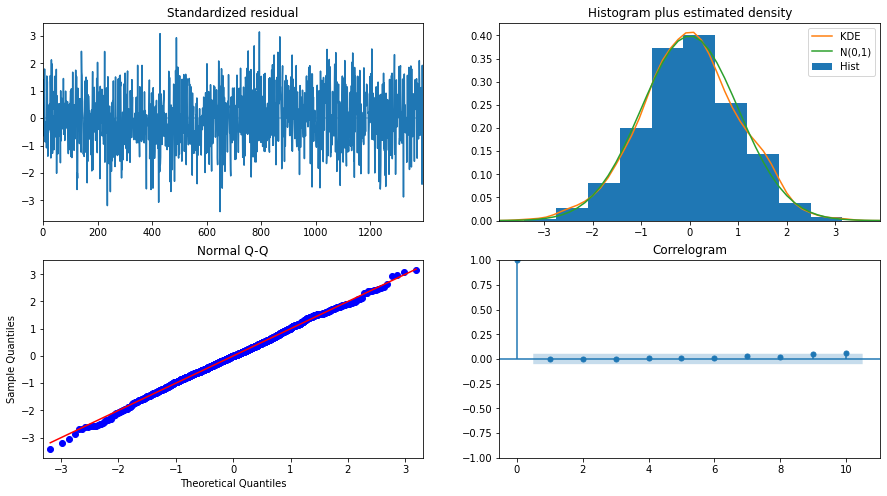

In [25]:
model.plot_diagnostics(figsize=(15,8));

In [26]:
def execute_forecast(pred, df_actual):
    results = pd.DataFrame(data={'date': df_actual.index, 'Predictions': pred, 'Actuals': df_actual[ATTR_NOW].values})
    results.set_index('date', inplace=True)
    
    plt.figure(figsize=(18,8))
    plt.title(f'Peramalan {ATTR_NAME} ARIMA')
    plt.plot(results.Predictions, 'b', label='Predictions')
    plt.plot(results.Actuals, 'r--', label='Actuals')
    plt.legend()
    plt.show
    
    MAE = mean_absolute_error(results.Actuals, results.Predictions)
    RMSE = sqrt(mean_squared_error(results.Actuals, results.Predictions))
    print(f'Mean Absolute Error is\t\t: {MAE}')
    print(f'Root Mean Squared Error is\t: {RMSE}')
    
    return results, MAE, RMSE

In [27]:
predictions = model.predict(n_periods = len(dtest), exogenous=test_exg)

In [28]:
predictions_inv = inv_boxcox(predictions, trans_lambdas)

Mean Absolute Error is		: 0.7512776061494335
Root Mean Squared Error is	: 0.913228653918052


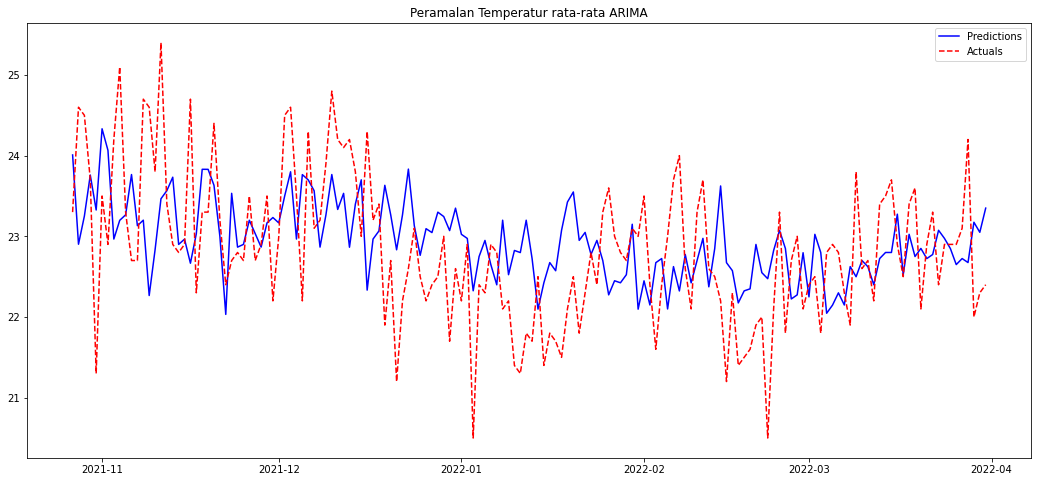

In [29]:
results, __, __ = execute_forecast(predictions_inv, dtest)

# Period Forecasting

In [30]:
def period_forecast(model_loc, period, data, exog):
    with open(model_loc, 'rb') as pkl:
        model = pickle.load(pkl) 
    predictions = []
    prog_count = 0
    for index in np.arange(0, len(data), period):
        if index+period > len(data) - 1:
            period = int(len(data) - index)
        print(f'Forecasting {period}-step from index {index}')
        results = model.predict(n_periods=period, exogenous=exog.iloc[index:index+period])
        for result in results:
            prog_count += 1
            predictions.append(result)
            print(f"result: {result}\t\tprocess: {prog_count}/{len(data)}")
        print('Updating the model...')
        model.update(data.iloc[index:index+period], exogenous=exog.iloc[index:index+period])
            
    return np.array(predictions)

In [31]:
test_trans = boxcox(dtest[ATTR_NOW], lmbda=trans_lambdas)
df_dtest_trans = dtest.copy()
df_dtest_trans[ATTR_NOW] = test_trans

### Forecast scenario 1 : 1 time step

In [32]:
%%time
sc1_forecast = period_forecast(model_loc, 1, df_dtest_trans, test_exg)

Forecasting 1-step from index 0
result: 19.02214632655638		process: 1/156
Updating the model...
Forecasting 1-step from index 1
result: 18.023245392696968		process: 2/156
Updating the model...
Forecasting 1-step from index 2
result: 18.730305851306813		process: 3/156
Updating the model...
Forecasting 1-step from index 3
result: 19.193778764765725		process: 4/156
Updating the model...
Forecasting 1-step from index 4
result: 18.653250901084014		process: 5/156
Updating the model...
Forecasting 1-step from index 5
result: 18.884426923684845		process: 6/156
Updating the model...
Forecasting 1-step from index 6
result: 18.820245370595455		process: 7/156
Updating the model...
Forecasting 1-step from index 7
result: 17.809414640018996		process: 8/156
Updating the model...
Forecasting 1-step from index 8
result: 18.46750478039639		process: 9/156
Updating the model...
Forecasting 1-step from index 9
result: 18.82961043552005		process: 10/156
Updating the model...
Forecasting 1-step from index 10

Forecasting 1-step from index 84
result: 18.194291683221216		process: 85/156
Updating the model...
Forecasting 1-step from index 85
result: 18.184744062858414		process: 86/156
Updating the model...
Forecasting 1-step from index 86
result: 17.8362973154951		process: 87/156
Updating the model...
Forecasting 1-step from index 87
result: 17.913209236011898		process: 88/156
Updating the model...
Forecasting 1-step from index 88
result: 17.76238454099098		process: 89/156
Updating the model...
Forecasting 1-step from index 89
result: 18.131332335562472		process: 90/156
Updating the model...
Forecasting 1-step from index 90
result: 17.891295270554245		process: 91/156
Updating the model...
Forecasting 1-step from index 91
result: 17.7637179820906		process: 92/156
Updating the model...
Forecasting 1-step from index 92
result: 18.156329762150506		process: 93/156
Updating the model...
Forecasting 1-step from index 93
result: 18.062210670785714		process: 94/156
Updating the model...
Forecasting 1-s

In [33]:
sc1_forecast_inv = inv_boxcox(sc1_forecast, trans_lambdas)

Mean Absolute Error is		: 0.6884182425355184
Root Mean Squared Error is	: 0.8586069075769835


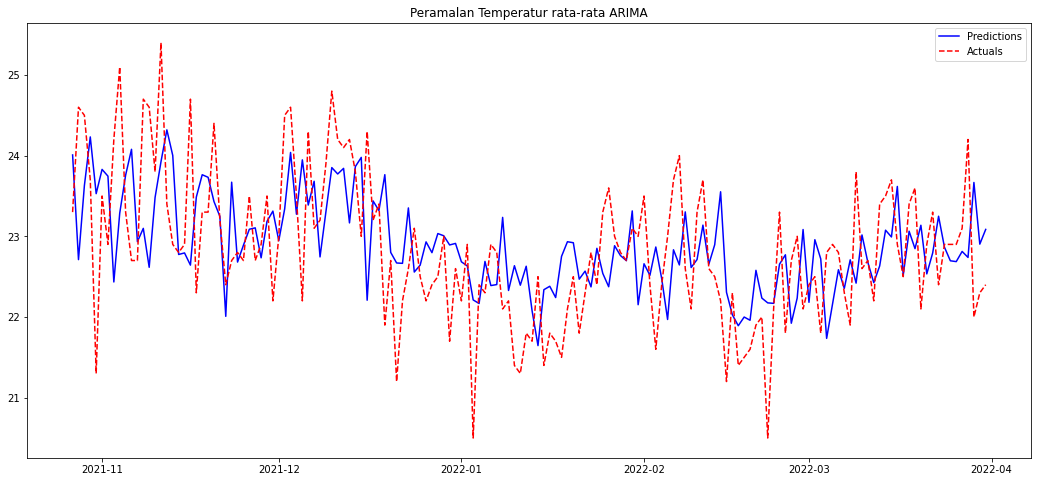

In [34]:
sc1_forecast_df, __, __ = execute_forecast(sc1_forecast_inv, dtest)

### Forecast scenario 2 : 3 time step

In [35]:
%%time
sc2_forecast = period_forecast(model_loc, 3, df_dtest_trans, test_exg)

Forecasting 3-step from index 0
result: 19.02214632655638		process: 1/156
result: 18.17042017230523		process: 2/156
result: 18.439679610675825		process: 3/156
Updating the model...
Forecasting 3-step from index 3
result: 19.1795264310856		process: 4/156
result: 18.744657253218577		process: 5/156
result: 19.395507328102532		process: 6/156
Updating the model...
Forecasting 3-step from index 6
result: 18.840916862052094		process: 7/156
result: 18.01118386394469		process: 8/156
result: 18.232526313360307		process: 9/156
Updating the model...
Forecasting 3-step from index 9
result: 18.829592296614287		process: 10/156
result: 19.157051315315304		process: 11/156
result: 18.52465684208434		process: 12/156
Updating the model...
Forecasting 3-step from index 12
result: 18.3313062584816		process: 13/156
result: 17.626074604110823		process: 14/156
result: 18.01629986006053		process: 15/156
Updating the model...
Forecasting 3-step from index 15
result: 18.937455122475686		process: 16/156
result: 18

Forecasting 3-step from index 132
result: 18.017571288744826		process: 133/156
result: 17.971714888729515		process: 134/156
result: 18.06654732961462		process: 135/156
Updating the model...
Forecasting 3-step from index 135
result: 17.99234057452826		process: 136/156
result: 17.795275474183907		process: 137/156
result: 18.004600971217872		process: 138/156
Updating the model...
Forecasting 3-step from index 138
result: 18.304751399073666		process: 139/156
result: 18.14673531222761		process: 140/156
result: 18.50796948227485		process: 141/156
Updating the model...
Forecasting 3-step from index 141
result: 17.871556533918152		process: 142/156
result: 18.29673796740025		process: 143/156
result: 18.05730548288666		process: 144/156
Updating the model...
Forecasting 3-step from index 144
result: 18.351920483864195		process: 145/156
result: 18.108925292953725		process: 146/156
result: 18.144246481765386		process: 147/156
Updating the model...
Forecasting 3-step from index 147
result: 18.437998

In [36]:
sc2_forecast_inv = inv_boxcox(sc2_forecast, trans_lambdas)

Mean Absolute Error is		: 0.7352396983494125
Root Mean Squared Error is	: 0.9039876593312958


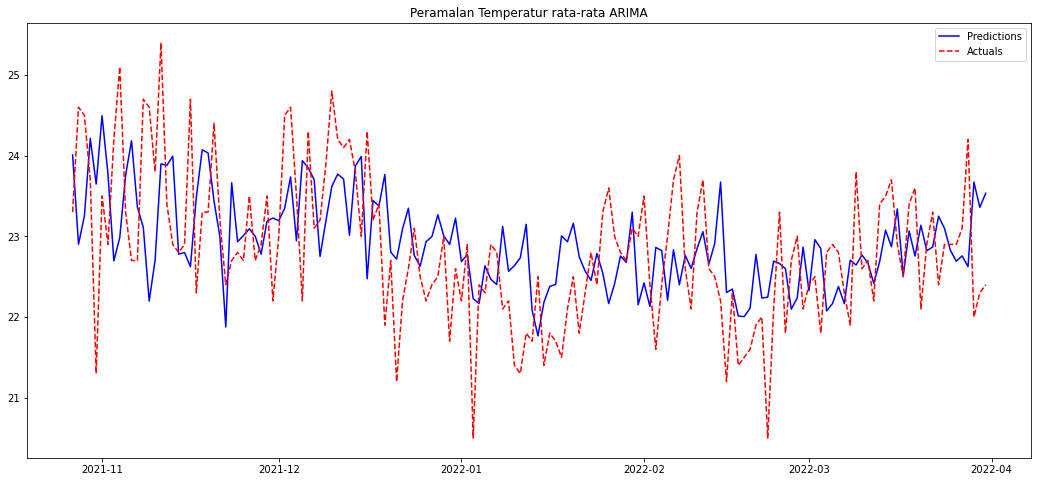

In [37]:
sc2_forecast_df, __, __ = execute_forecast(sc2_forecast_inv, dtest)

### Forecast scenario 3 : 7 time step

In [38]:
%%time
sc3_forecast = period_forecast(model_loc, 7, df_dtest_trans, test_exg)

Forecasting 7-step from index 0
result: 19.02214632655638		process: 1/156
result: 18.17042017230523		process: 2/156
result: 18.439679610675825		process: 3/156
result: 18.83072668720666		process: 4/156
result: 18.49747220203533		process: 5/156
result: 19.27121255271725		process: 6/156
result: 19.06639283706691		process: 7/156
Updating the model...
Forecasting 7-step from index 7
result: 17.826729202185305		process: 8/156
result: 18.12214768387777		process: 9/156
result: 18.23242778175926		process: 10/156
result: 18.787762182827123		process: 11/156
result: 18.305351347935986		process: 12/156
result: 18.406971641286017		process: 13/156
result: 17.682046630327896		process: 14/156
Updating the model...
Forecasting 7-step from index 14
result: 18.62382028021423		process: 15/156
result: 18.876822492468268		process: 16/156
result: 18.8964307389296		process: 17/156
result: 18.996789222418162		process: 18/156
result: 18.28695752200671		process: 19/156
result: 18.209208351904962		process: 20/156


In [39]:
sc3_forecast_inv = inv_boxcox(sc3_forecast, trans_lambdas)

Mean Absolute Error is		: 0.7330003203003909
Root Mean Squared Error is	: 0.8954760374906058


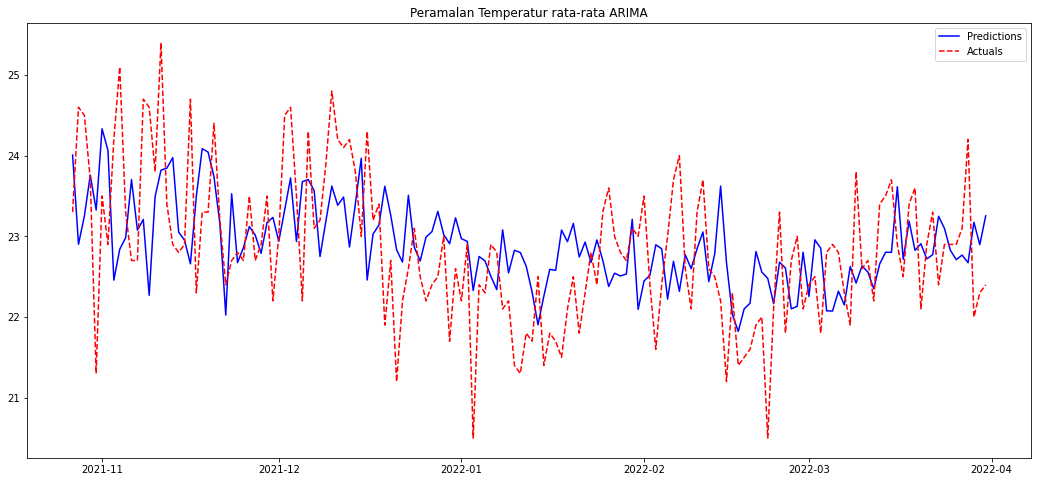

In [40]:
sc3_forecast_df, __, __ = execute_forecast(sc3_forecast_inv, dtest)

# Collecting All Predictions Scenario Result

In [41]:
def plot_forecasts_result(res_df):
    title = 'Peramalan ' + ATTR_NAME + ' ARIMA'
    
    plt.figure(figsize=(18,8))
    plt.title(title)
    plt.plot(res_df['scn-1'], 'r-', label='1-step forecast')
    plt.plot(res_df['scn-2'], 'b-', label='3-step forecast')
    plt.plot(res_df['scn-3'], 'g-', label='7-step forecast')
    plt.plot(res_df['Actuals'], color='black', linestyle=':' , label='Actuals')
    plt.legend()

In [42]:
def col_forcasts_err(res_df):
    for col in [x for x in range(len(forecasts_result.columns)-1)]:
        col_name = res_df.columns[col]
        MAE = mean_absolute_error(res_df['Actuals'], res_df[col_name])
        RMSE = sqrt(mean_squared_error(res_df['Actuals'], res_df[col_name]))
        print('Error for ', col_name)
        print(f'Mean Absolute Error is\t\t: {MAE}')
        print(f'Root Mean Squared Error is\t: {RMSE}')
        print()

In [43]:
sc1_df_cp = sc1_forecast_df.copy()
sc1_df_cp.columns = ['scn-1', 'Actuals']

sc2_df_cp = sc2_forecast_df.copy()
sc2_df_cp.columns = ['scn-2', 'Actuals']

sc3_df_cp = sc3_forecast_df.copy()
sc3_df_cp.columns = ['scn-3', 'Actuals']

In [44]:
forecasts_result = pd.concat([sc1_df_cp[[sc1_df_cp.columns[0]]],
                              sc2_df_cp[[sc2_df_cp.columns[0]]],
                              sc3_df_cp[[sc3_df_cp.columns[0]]],
                              sc1_df_cp[[sc3_df_cp.columns[1]]]
                             ],
                               axis='columns')

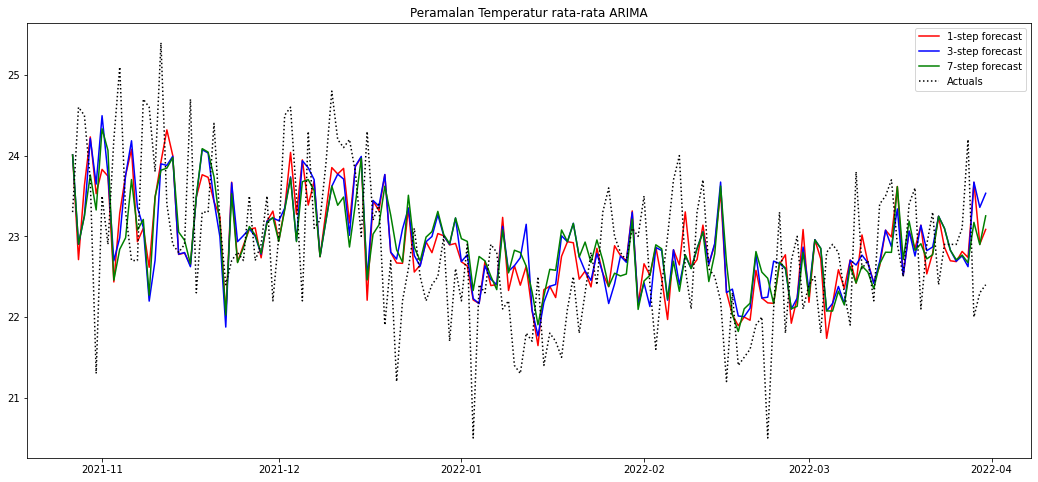

In [45]:
plot_forecasts_result(forecasts_result)

In [46]:
col_forcasts_err(forecasts_result)

Error for  scn-1
Mean Absolute Error is		: 0.6884182425355184
Root Mean Squared Error is	: 0.8586069075769835

Error for  scn-2
Mean Absolute Error is		: 0.7352396983494125
Root Mean Squared Error is	: 0.9039876593312958

Error for  scn-3
Mean Absolute Error is		: 0.7330003203003909
Root Mean Squared Error is	: 0.8954760374906058



## Saving forecasts result

In [47]:
forecasts_result.to_csv('ARIMA_results/'+ATTR_NOW+'.csv')